# How well can subjects tell conditions apart? (second attempt)

Since we cannot directly ask subjects if and when they perceive to be in a different condition, the goal here is using EEG data to predict the condition. 

EEG $\Rightarrow$ internal variables of the subject

## Task : build a condition classifier trained on single subjects

We can address questions such as:
  + Can we make predictions based on single trials, or averages on minibatches?
  + Can we discriminate by EEG signal all 4 classes? Which ones are more likely mixed up?
  + Any difference between ASD and NTP ? 
  + Which elements of the task are relevant? (e.g. target stimulus, vs catch, vs 2nd target, etc)

### Part 1 , read data


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.io as io
from pprint import pprint

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold, StratifiedKFold

import sys
from IPython.display import clear_output

import seaborn as sns #pip3 install seaborn
from datetime import date
import matplotlib.pyplot as plt

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

def verbose(text):    
    clear_output(wait=True)    
    print(text)
    sys.stdout.flush() 
    
def errorfill(x, y, yerr, color=None, label=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.get_next_color()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color, label=label)
    ax.fill_between(x, ymax, ymin, color=color, label=label, alpha=alpha_fill)
    return ax

def baselinestring(baseline=None):
    if baseline is None:
        basemethod=''
    elif (baseline is 50) or (baseline is 100):
        basemethod = f"baseline{baseline}"
    else:
        raise ValueError("baseline is nothing, 50 or 100")
    return basemethod

def read_data_erps(baseline=None):
    read_dir = '../shareddata/' + 'seyda'+'/'
    bmethod=baselinestring(baseline)
    read_filename = read_dir+'ERPs-'+bmethod+'.npz'
    assert (os.path.isfile(read_filename)),"file not found"
    data = np.load(read_filename, allow_pickle=True)
    return data['ERPs'],data['subjects']

def read_data_xall(baseline=None):
    read_dir = '../shareddata/' + 'seyda'+'/'
    bmethod=baselinestring(baseline)
    read_filename = read_dir+'X_all-'+bmethod+'.npz'
    assert (os.path.isfile(read_filename)),"file not found"
    data = np.load(read_filename, allow_pickle=True)
    return data['X_all'],data['subjects']

In [ ]:
# Slooooooow ! 
ERPs,subjects = read_data_erps(50) #n_trtype, n_conds,n_subj, n_time, n_elec 

In [ ]:

trialTypes=['item1','item2','target','invalidThird','correct','catch','easyFiller','ctrlFiller']
n_trtype, n_conds,n_subj, n_time, n_elec = ERPs.shape
assert (n_subj == subjects.shape[0]),"something wrong with subject number?"

In [43]:
#subj2exclude=['10056','12144','12360','1160','12005']
subj2exclude=['10594']
ind_ex = [i for i in range(subjects.shape[0]) if subjects[i,2] in subj2exclude]
if len(ind_ex) > 0:
    X_all = np.delete(X_all, ind_ex, axis=2)
    subjects = np.delete(subjects, ind_ex, axis=0)
    print(f"Removed {len(ind_ex)} subjects")
else:
    print('No subjects to remove!')
assert (subjects.shape[0] == X_all.shape[2]) , 'Subject size does not match to the data'

No subjects to remove!


### Part 2 , take a look at the data

Pick one subject, plot C1 Vs C4  in time, averaged over everything else


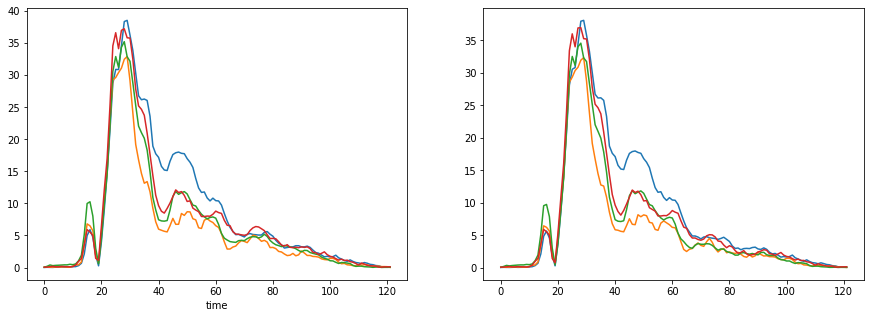

In [74]:
test_subj_idx = 4
X_all_testc1 = X_all[:,0,test_subj_idx,:,:]
X_all_testc2 = X_all[:,1,test_subj_idx,:,:]
X_all_testc3 = X_all[:,2,test_subj_idx,:,:]
X_all_testc4 = X_all[:,3,test_subj_idx,:,:]

def meanstuff(X):
    return np.mean(X.mean(axis=0)**2,axis=1)

def varstuff(X):
    return np.var(X.mean(axis=0),axis=1)

X_all_testplotc1 = meanstuff(X_all_testc1)
X_all_testplotc2 = meanstuff(X_all_testc2)
X_all_testplotc3 = meanstuff(X_all_testc3)
X_all_testplotc4 = meanstuff(X_all_testc4)

X_all_testvarc1 = varstuff(X_all_testc1)
X_all_testvarc2 = varstuff(X_all_testc2)
X_all_testvarc3 = varstuff(X_all_testc3)
X_all_testvarc4 = varstuff(X_all_testc4)

plot_times = np.array(range(n_time))

fig,(plt1,plt2) = plt.subplots(1,2)

plt1.plot(plot_times,X_all_testplotc1,plot_times,X_all_testplotc2, 
          plot_times,X_all_testplotc3, 
        plot_times,X_all_testplotc4)
fig.set_size_inches(15,5)

plt2.plot(plot_times,X_all_testvarc1,plot_times,X_all_testvarc2, 
          plot_times,X_all_testvarc3, 
        plot_times,X_all_testvarc4)
plt1.set_xlabel('time');

Just out of curiosity, do trial types look very different? Maybe I should not average on them.... (for the training I definitely will not)
Compare trial types for only one condition

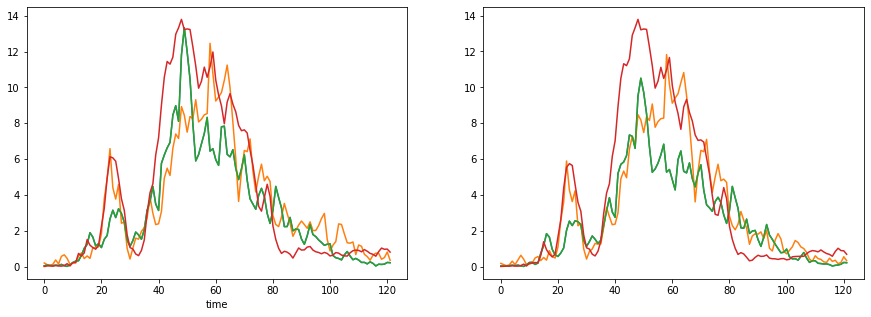

In [83]:
test_subj_idx = 1
test_cond_idx = 0
X_all_testc1 = X_all[6,test_cond_idx,test_subj_idx,:,:]
X_all_testc2 = X_all[3,test_cond_idx,test_subj_idx,:,:]
X_all_testc3 = X_all[6,test_cond_idx,test_subj_idx,:,:]
X_all_testc4 = X_all[2,test_cond_idx,test_subj_idx,:,:]

def meanstuff(X):
    return np.mean(X**2,axis=1)

def varstuff(X):
    return np.var(X,axis=1)

X_all_testplotc1 = meanstuff(X_all_testc1)
X_all_testplotc2 = meanstuff(X_all_testc2)
X_all_testplotc3 = meanstuff(X_all_testc3)
X_all_testplotc4 = meanstuff(X_all_testc4)

X_all_testvarc1 = varstuff(X_all_testc1)
X_all_testvarc2 = varstuff(X_all_testc2)
X_all_testvarc3 = varstuff(X_all_testc3)
X_all_testvarc4 = varstuff(X_all_testc4)

plot_times = np.array(range(n_time))

fig,(plt1,plt2) = plt.subplots(1,2)

plt1.plot(plot_times,X_all_testplotc1,plot_times,X_all_testplotc2, 
          plot_times,X_all_testplotc3, 
        plot_times,X_all_testplotc4)
fig.set_size_inches(15,5)

plt2.plot(plot_times,X_all_testvarc1,plot_times,X_all_testvarc2, 
          plot_times,X_all_testvarc3, 
        plot_times,X_all_testvarc4)
plt1.set_xlabel('time');

**Conclusion :** yes, traces on average aver very different across conditions... but they are also different comparing different trial types. 

**PROBLEM** if I want to 

### Part 3, classification C1 Vs C4

Just to move in known territory, I will do logistic regression, c1 Vs c4. 

Since data is already averaged over trials, I will consider multiple conditions at the same time. Conditions are selected by an index, I will start with all of them. 

X contains  1 subject, variance across all electrodes, 122 timesteps * n_cond (8 or less) trial types. 

So it's a pipeline, with PCA first, then logistic regression.

In [15]:
vals_pca_components = np.arange(1,35,2)
vals_C =np.logspace(-4, 0, 5)
model_pca = PCA()
model_lr = LogisticRegression(max_iter=5000, tol=1.0,penalty='l1')
pipe = Pipeline(steps=[('pca',pca),('log_regr',lg) ])
pipe_param_grid = {'pca__n_components':vals_pca_components, 
                  'log_regr__C':vals_C}

# clfs['LR-L2']= LogisticRegression(max_iter=5000, tol=1.0) #default=’l2’
# clfs['LR-L1']= LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000, tol=1.0)
# clfs['LDA']=  LinearDiscriminantAnalysis(tol=1e-3)
# clfs['QDA'] = QuadraticDiscriminantAnalysis(tol=1e-3)


In [26]:

modelfits01 = np.zeros((n_subj,n_trtype), dtype=object)

for ij in np.ndindex(modelfits01.shape):
    i,j=ij
    # X defined as subject i , trial type j , variance over channels, all times, all trials
    # condition either 1 or 4 
    # (suboptimal appoach, copy conditions separately, then cat them) 
    X0 = X_all[j,None,0,i,:,:] # condition, time, electrode
    X0 = np.var(X0,)            


for i in range(n_trtype):
    for j in range(n_conds):
        X = X_all[i,j].reshape(n_subj,n_time*n_elec)**2        
        #X -= X.mean(0, keepdims=True)
        # /= X.std(0, keepdims=True)
        search_8x4[i,j] = GridSearchCV(pipe_8x4, param_grid, cv=5, n_jobs=15, verbose=0)
        search_8x4[i,j].fit(X, y);
        verbose('%i,%i'%(i,j))

run_8x4_identifier=clf_key_8x4+'-pca'+str(param_grid['pca__n_components'].shape[0])+'-C'+str(param_grid['clf__C'].shape[0])+'-'+str(X.shape[1])+'features'
save_name='results-8x4-'+baseMethod+'-'+run_8x4_identifier+'.npz'  #date.today().strftime('--%d-%m-%Y')
np.savez(save_dir+save_name,search_8x4=search_8x4)


7,3


In [ ]:
search_8x1 = np.zeros(n_trtype, dtype=object)
for i in range(n_trtype):
    X = X_all[i].reshape(n_subj,n_time*n_elec*n_conds)
    search_8x1[i] = GridSearchCV(pipe_8x1, param_grid, cv=5, n_jobs=15, verbose=0)
    search_8x1[i].fit(X, y);
    verbose('%i'%(i))

run_8x1_identifier=clf_key_8x1+'-pca'+str(param_grid['pca__n_components'].shape[0])+'-C'+str(param_grid['clf__C'].shape[0])+'-'+str(X.shape[1])+'features'
save_name='results-8x1-'+baseMethod+'-'+run_8x1_identifier+'.npz'  #date.today().strftime('--%d-%m-%Y')
np.savez(save_dir+save_name,search_8x1=search_8x1)
    

7


In [ ]:
# Combine results from 8x4 and 8x1 results together into 8x5

bestScores=np.zeros((n_trtype,n_conds+1),dtype=int)
best_c=np.zeros((n_trtype,n_conds+1),dtype=float)
best_nPCA=np.zeros((n_trtype,n_conds+1),dtype=int)

for i in range(n_trtype):
    for j in range(n_conds):
        bestScores[i,j] = search_8x4[i,j].best_score_*100
        best_c[i,j]=search_8x4[i,j].best_params_['clf__C']
        best_nPCA[i,j]=search_8x4[i,j].best_params_['pca__n_components']
        
    bestScores[i,j+1] = search_8x1[i].best_score_*100
    best_c[i,j+1]=search_8x1[i].best_params_['clf__C']
    best_nPCA[i,j+1]=search_8x1[i].best_params_['pca__n_components']


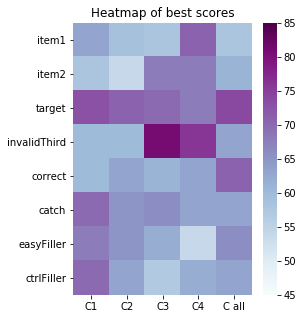

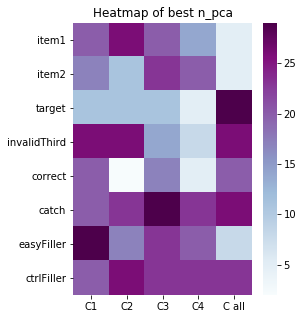

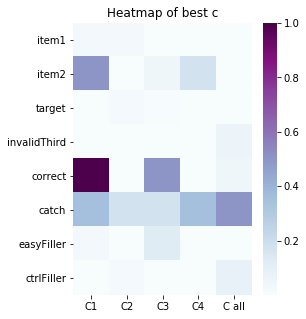

In [ ]:
# Plot best scores and parameters 
run_identifier=clf_key_8x4+'+'+clf_key_8x1+'-pca'+str(param_grid['pca__n_components'].shape[0])+'-C'+str(param_grid['clf__C'].shape[0])+'-'+str(X.shape[1])+'features'
conds=['C1','C2','C3','C4','C all']

fig = plt.figure(figsize=(4,5))
r = sns.heatmap(bestScores, cmap='BuPu',vmin=45, vmax=85,xticklabels=conds,yticklabels=trialTypes)
r.set_title("Heatmap of best scores")
plt.savefig(save_dir+'heatmap-best-scores-'+run_identifier+'.png')

fig = plt.figure(figsize=(4,5))
r = sns.heatmap(best_nPCA, cmap='BuPu',xticklabels=conds,yticklabels=trialTypes)
r.set_title("Heatmap of best n_pca")
plt.savefig(save_dir+'heatmap-best-npc-'+run_identifier+'.png')

fig = plt.figure(figsize=(4,5))
r = sns.heatmap(best_c, cmap='BuPu',xticklabels=conds,yticklabels=trialTypes)
r.set_title("Heatmap of best c")
plt.savefig(save_dir+'heatmap-best-c-'+run_identifier+'.png')


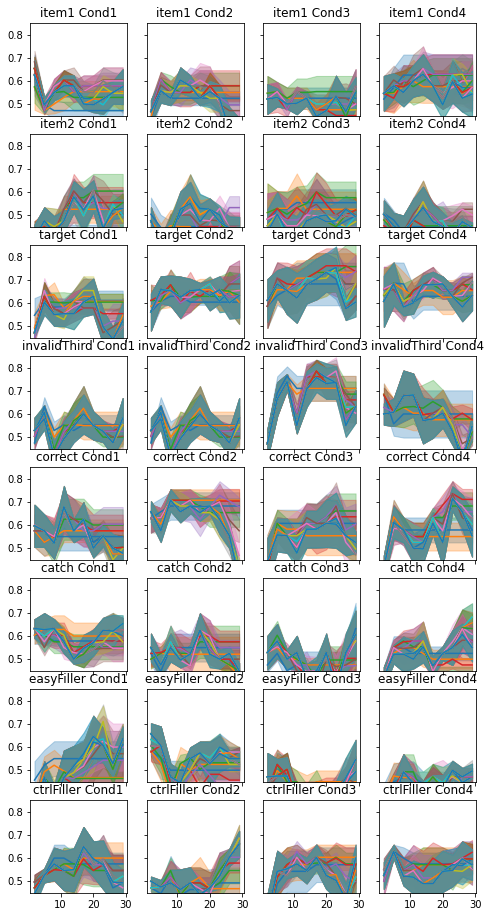

In [82]:
fig, ax = plt.subplots(n_trtype,n_conds,figsize=(n_conds*2,n_trtype*2),sharey=True,sharex=True)
for i in range(n_trtype):
    for j in range(n_conds):
        #print("Best parameter (CV score=%0.3f):" % search_all[i,j].best_score_)
        #print(search_all[i,j].best_params_)
        clf_key_8x4='LR-L2'
        if clf_key_8x4 in ['LR-L1','LR-L2']:
            for k in range(test_C.shape[0]):
                errorfill(test_pca,search_8x4[i,j].
                          cv_results_['mean_test_score']
                          .reshape(test_C.shape[0],test_pca.shape[0])[k].T,
                          search_8x4[i,j].cv_results_['std_test_score']
                          .reshape(test_C.shape[0],test_pca.shape[0])[k].T
                              /np.sqrt(5), ax=ax[i,j])
                ax[i,j].set_ylim(0.45,0.85)
                ax[i,j].title.set_text(trialTypes[i]+' '+'Cond'+str(j+1))
            
        else:
            errorfill(test_pca,search_8x4[i,j].cv_results_['mean_test_score'],
                      search_8x4[i,j].cv_results_['std_test_score']/np.sqrt(5),
                      ax=ax[i,j])    
        ax[i,j].set_ylim(0.45,0.85)
        
plt.savefig(save_dir+'fig-scores-8x4-'+run_8x4_identifier+'.png')


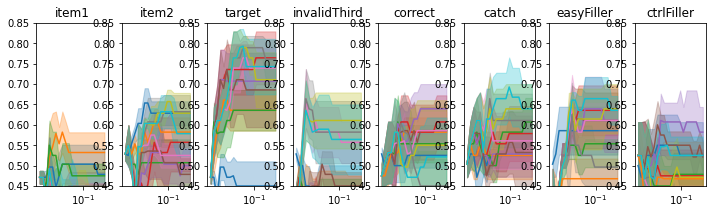

In [83]:
fig, ax = plt.subplots(1, n_trtype, figsize=(12,3))
for i in range(n_trtype):
    #print("Best parameter (CV score=%0.3f):" % search_8x1[i].best_score_)
    #print(search_8x1[i].best_params_)
    for k in range(test_pca.shape[0]):
        errorfill(test_C,search_8x1[i].
                  cv_results_['mean_test_score']
                  .reshape(test_C.shape[0],test_pca.shape[0])[:,k],
                  search_8x1[i].cv_results_['std_test_score']
                  .reshape(test_C.shape[0],test_pca.shape[0])[:,k]/np.sqrt(5),
                  ax=ax[i])

    ax[i].set_xscale('log')
    ax[i].set_ylim(0.45,0.85)
    ax[i].title.set_text(trialTypes[i])
    
plt.savefig(save_dir+'fig-scores-8x1-'+run_8x1_identifier+'.png')


0
2
4
0
0
5
4
0


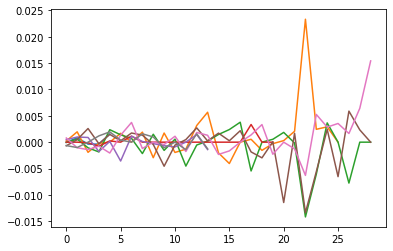

In [44]:
for i in range(n_trtype):
    #print(np.abs(search_l1_all[i].best_estimator_['clf'].coef_))
    print(np.sum(np.abs(search_8x1[i].best_estimator_['clf'].coef_)>0.5e-2))
    plt.plot(search_8x1[i].best_estimator_['clf'].coef_.T)

## Things to try
- Use non-linear methods like kernel methods (but we are already overfitting)
- Craft our own Quadratic Discriminant Analysis with diagonal cov matrices
- Use L1 penalty + logistic regression (highly relevant to find a relevant low dimensional space)
- Use brute force PCA components selection (using all intervals [i,j])
- do channel selection and time windows selection